# House Prices Exploratory Data Analysis
This is based on the detailed EDA of Erik Bruin's R Notebook
https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda

In [1720]:
# Import standard libraries needed for data exploration 
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from collections import OrderedDict

In [1721]:
# Define the path and file names
PATH = 'data/'
PATH_TRAIN = PATH + 'train.csv' 
PATH_TEST = PATH + 'test.csv' 
PATH_DESC = PATH + 'data_description.txt' 


In [1722]:
# Read the train and test database
train_db = pd.read_csv(PATH_TRAIN)
test_db = pd.read_csv(PATH_TEST)

In [1723]:
# Get the size of the database
print('Size of train database:', train_db.shape)
print('Size of test database:', test_db.shape)

Size of train database: (1460, 81)
Size of test database: (1459, 80)


In [1724]:
# Display some training data
train_db.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1438]:
# Drop the Id
train_Id = train_db['Id'] # Store it seperately incase we need to use it later
train_db = train_db.drop(['Id'],axis = 1)

In [1439]:
# Drop the Id
test_Id = test_db['Id'] # Store it seperately incase we need to use it later
test_db = test_db.drop(['Id'],axis = 1)

## Exploring relationships of variables
### SalePrice

The SalePrice is right skewed, there are fewer expensive house. For modeling we will have to correct the skewness before sending it to ML algorithim

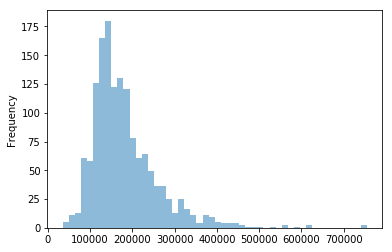

In [1440]:
# SalePrice distribution
train_db['SalePrice'].plot.hist(bins = 50, alpha = 0.5);

In [1441]:
# Statistics of SalePrice
#print('SalePrice Mean:{0:.2f} and Standard Deviation {1:.2f}'.format(train_db['SalePrice'].mean(),train_db['SalePrice'].std()))
train_db['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Explore correlations with SalePrice

In [1442]:
correlations = train_db.corr()
# Pick the top 10 variables
indx_corr_SalePrice = list(correlations['SalePrice'].sort_values(ascending = False)[0:10].index)
corr_SalePrice = train_db[indx_corr_SalePrice].corr()

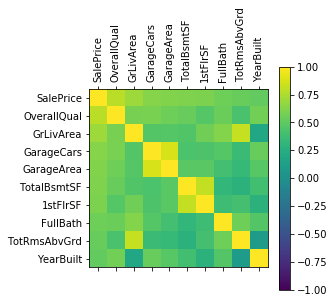

In [1443]:
plt.matshow(corr_SalePrice, vmin = -1, vmax = 1);
plt.colorbar();
plt.xticks(range(len(indx_corr_SalePrice)), indx_corr_SalePrice, rotation = 'vertical');
plt.yticks(range(len(indx_corr_SalePrice)), indx_corr_SalePrice, rotation = 'horizontal');

The two variables SalePrice of home is strongly correlated are 
- Overall Quality of house the type of finishing in the house etc
- Above Ground Living Area, the total livable area in the house

Several variables like Garage Cars and Garage Area are strongly correlated to themseleves and also to SalePrice, indicating issues of multicolinearity of variables 

### Overall Quality

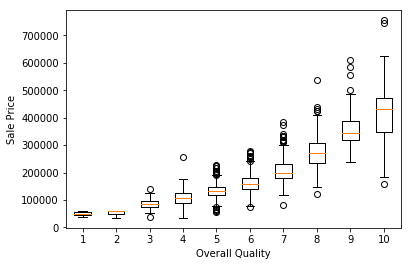

In [1444]:
box_plot_data = [] 
for i in set(train_db['OverallQual'].values):
    subset = train_db[train_db['OverallQual'] == i]
    box_plot_data.append(subset['SalePrice'].values)
plt.boxplot(box_plot_data);
plt.xlabel('Overall Quality');
plt.ylabel('Sale Price');

Postive correlation exist between SalePrice and Overall Quality. However higher spread exist between the homes of Higher Quality. The line in the box tells us the median, the box represents the 25th to 75th percentiles (middle 50% of data) and the whiskers give an idea of the spread pf the data. The markers outside the whiskers are indication of candidate outlier values. 

### Above Ground Living Area
The Sales Price is highly correlated with Total above ground living area, i.e. more is livable area (not farm acreage) greater is the price  

Correlation coefficient between Above Ground Living Area and Sales Price 0.71


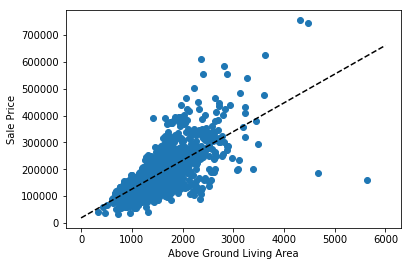

In [1445]:
plt.scatter(train_db['GrLivArea'].values,train_db['SalePrice'].values);
plt.xlabel('Above Ground Living Area')
plt.ylabel('Sale Price')
slope, intercept = np.polyfit(train_db['GrLivArea'].values,train_db['SalePrice'].values,1)
plt.plot(np.arange(0,6000),intercept + np.arange(0,6000)*slope, 'k--');
print('Correlation coefficient between Above Ground Living Area and Sales Price {:.2f}'.format(np.corrcoef(train_db['GrLivArea'].values,train_db['SalePrice'].values)[0,1]))

We can see that there are several outliers to this data, at lower Sales Price side we have houses with >4000 sq ft living area sold for < 200k dollars. We will examine these outliers to see if they have any thing special in them or else remove them as outliers


In [1446]:
candidate_outlier = train_db[(train_db['GrLivArea'] > 4000.0) * ((train_db['SalePrice'] < 200000.0))]

In [1447]:
candidate_outlier[indx_corr_SalePrice]


,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt
523,184750,10,4676,3,884,3138,3138,3,11,2007
1298,160000,10,5642,2,1418,6110,4692,2,12,2008


House number indexed by 523 and 1298 are both high overall quality, big houses which were sold at a heavily discounted rate. These houses are current outliers since laking external factors (like seller distress sale etc.) we would have expected to be sold at much higher rate  

In [1448]:
train_db_ = train_db # Save original
train_db = train_db.drop([523,1298]);

New correlation coefficient between Above Ground Living Area and Sales Price 0.73


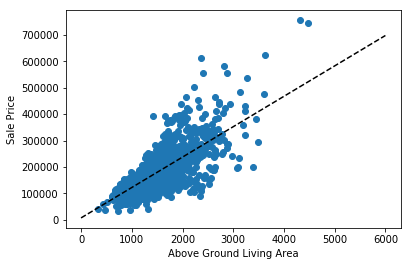

In [1449]:
plt.scatter(train_db['GrLivArea'].values,train_db['SalePrice'].values);
plt.xlabel('Above Ground Living Area')
plt.ylabel('Sale Price')
slope, intercept = np.polyfit(train_db['GrLivArea'].values,train_db['SalePrice'].values,1)
plt.plot(np.arange(0,6000),intercept + np.arange(0,6000)*slope, 'k--');
print('New correlation coefficient between Above Ground Living Area and Sales Price {:.2f}'.format(np.corrcoef(train_db['GrLivArea'].values,train_db['SalePrice'].values)[0,1]))

## Dealing with missing data and variable encoding

### Check for Null, NaN values

Find variables with missing data

In [1450]:
count_null =dict()
# First cycle through training
for column in train_db.columns:
    num_null =len((train_db[column])[pd.isna(train_db[column])])
    count_null[column] = num_null
# Then cycle through test data
for column in test_db.columns:
    num_null =len((test_db[column])[pd.isna(test_db[column])])
    count_null[column]+=num_null

count_null_keys = list(count_null.keys())
for key in count_null_keys:
    if count_null[key] == 0:
        count_null.pop(key) 
count_null

{'MSZoning': 4,
 'LotFrontage': 486,
 'Alley': 2719,
 'Utilities': 2,
 'Exterior1st': 1,
 'Exterior2nd': 1,
 'MasVnrType': 24,
 'MasVnrArea': 23,
 'BsmtQual': 81,
 'BsmtCond': 82,
 'BsmtExposure': 82,
 'BsmtFinType1': 79,
 'BsmtFinSF1': 1,
 'BsmtFinType2': 80,
 'BsmtFinSF2': 1,
 'BsmtUnfSF': 1,
 'TotalBsmtSF': 1,
 'Electrical': 1,
 'BsmtFullBath': 2,
 'BsmtHalfBath': 2,
 'KitchenQual': 1,
 'Functional': 2,
 'FireplaceQu': 1420,
 'GarageType': 157,
 'GarageYrBlt': 159,
 'GarageFinish': 159,
 'GarageCars': 1,
 'GarageArea': 1,
 'GarageQual': 159,
 'GarageCond': 159,
 'PoolQC': 2908,
 'Fence': 2346,
 'MiscFeature': 2812,
 'SaleType': 1}

In [1451]:
print('Number of variables with missing data {}'.format(len(count_null.keys())))

Number of variables with missing data 34


In [1452]:
# Read description
def read_description(feature):
    # Read the description of PoolQC to figure out variable type
    with open(PATH_DESC,'r') as description:
        for line in description:
            if feature in line.split(':'):
                print(line)
                line = description.readline()
                while ':' not in line:
                    print(line)
                    line = description.readline()

In [1453]:
# Encode as ordinal
def encode_ordinal(variable, db, levels):
    # Encode levels as integers
    for key in levels.keys():
        indx = (db[variable] == key)
        db[variable][indx] = levels[key]


#### Pool Quality
This variable has the highest number of missing values, first we will read in the description to understand how has PoolQC been defined in our data

In [1454]:
# Read the description of PoolQC to figure out variable type
read_description('PoolQC')

PoolQC: Pool quality

		

       Ex	Excellent

       Gd	Good

       TA	Average/Typical

       Fa	Fair

       NA	No Pool

		



Since we expect most houses not to have pools we will assign the missing values to 'No Pool' category. However we must note that we also have PoolArea available to us, if PoolArea > 0 then the house has a pool and we must assign it a quality, we can use the Overall Quality as measure of how good the pool will be and use it to set the PoolQC

We will encode PooLQC variable as an ordinal with integer values

In [1455]:
# Reset data
#train_db = train_db_ # Save original
#train_db = train_db.drop([523,1298]);
#train_db

In [1456]:
Qualities = {
    'NA':0,
    'Fa':1,
    'TA':2,
    'Gd':3,
    'Ex':4
}

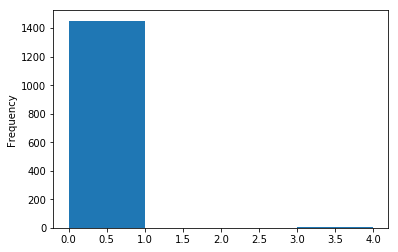

In [1457]:
var_scan = 'PoolQC'
# Change all NaNs to NA, which is No Pool
train_db[var_scan][pd.isna(train_db[var_scan])] = 'NA'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)

train_db[var_scan].plot.hist(bins = 4);

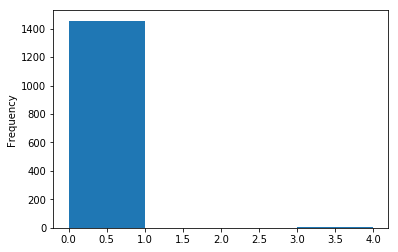

In [1458]:
var_scan = 'PoolQC'
# Change all NaNs to NA, which is No Pool
test_db[var_scan][pd.isna(test_db[var_scan])] = 'NA'
# Encode levels as integers
encode_ordinal(var_scan, test_db, Qualities)
test_db[var_scan].plot.hist(bins = 4);

In [1459]:
train_db[(train_db['PoolQC'] == 0).values & (train_db['PoolArea'] > 0).values]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [1460]:
test_db[(test_db['PoolQC'] == 0).values & (test_db['PoolArea'] > 0).values]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
960,20,RL,75.0,9532,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,368,0,GdPrv,NaN,0,2,2007,WD,Normal
1043,50,RL,104.0,23920,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,444,0,NaN,NaN,0,4,2007,WD,Normal
1139,20,RL,200.0,43500,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,561,0,GdPrv,NaN,0,6,2007,WD,Normal


In [1461]:
# Find the Overall Qualtiy which we will use for imputing the missing PoolQC
test_db.loc[[960,1043,1139]][['OverallQual','PoolArea','PoolQC']]

,OverallQual,PoolArea,PoolQC
960,4,368,0
1043,6,444,0
1139,3,561,0


In [1462]:
# Set the Pool QC (scale of 5) based on Overall QC (scale of 10)
test_db['PoolQC'].iloc[[960,1043,1139]] = [2,3,2]

#### Misc Features
Features of the house not described by other varaibles in the dataset

In [1463]:
# Read the description of MiscFeature to figure out variable type
read_description('MiscFeature')

MiscFeature: Miscellaneous feature not covered in other categories

		

       Elev	Elevator

       Gar2	2nd Garage (if not described in garage section)

       Othr	Other

       Shed	Shed (over 100 SF)

       TenC	Tennis Court

       NA	None

		



We will replace all NaN values by NA

In [1464]:
var_scan = 'MiscFeature'
# Change all NaNs to NA, which is No Pool
train_db[var_scan][pd.isna(train_db[var_scan])] = 'NA'
test_db[var_scan][pd.isna(test_db[var_scan])] = 'NA'

In [1465]:
# Counts for different features, train set
pd.value_counts(train_db['MiscFeature'])

NA      1404
Shed      49
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64

In [1466]:
# Counts for different features, train set
pd.value_counts(test_db['MiscFeature'])

NA      1408
Shed      46
Gar2       3
Othr       2
Name: MiscFeature, dtype: int64

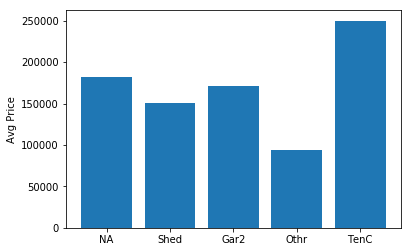

In [1467]:
value = []
feature = list(train_db['MiscFeature'].unique())
for category in feature:
    value.append(train_db['SalePrice'][train_db['MiscFeature'] == category].mean())
plt.bar(feature,value);
plt.ylabel('Avg Price');

The 'MiscFeature' variable cannot be easily cast as an ordinal, though it make sense that having a Tennis Court will mean the price of house should be higher there is only one house with a tennis court in the data base. 

We will convert the MiscFeature to factors

In [1468]:
# We will convert all features to factors after we have analyzed all features
convert_factors = ['MiscFeature']

#### Alley
Type of alley access to the property

In [1469]:
# Read the description of Alley to figure out variable type
read_description('Alley')

Alley: Type of alley access to property



       Grvl	Gravel

       Pave	Paved

       NA 	No alley access

		



We will replace all NaN values by NA

In [1470]:
var_scan = 'Alley'
# Change all NaNs to NA, which is No Pool
train_db[var_scan][pd.isna(train_db[var_scan])] = 'NA'
test_db[var_scan][pd.isna(test_db[var_scan])] = 'NA'

In [1471]:
# Counts for different features, train set
pd.value_counts(train_db['Alley'])

NA      1367
Grvl      50
Pave      41
Name: Alley, dtype: int64

In [1472]:
# Counts for different features, test set
pd.value_counts(test_db['Alley'])

NA      1352
Grvl      70
Pave      37
Name: Alley, dtype: int64

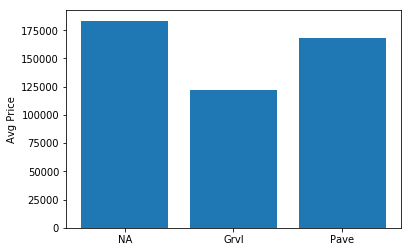

In [1473]:
value = []
feature = list(train_db['Alley'].unique())
for category in feature:
    value.append(train_db['SalePrice'][train_db['Alley'] == category].mean())
plt.bar(feature,value);
plt.ylabel('Avg Price');

No particular trend between house which have gravel, pavement or None, we will convert this variable to a factor

In [1474]:
convert_factors.append('Alley')

#### Fence
Type of alley access to the property

In [1475]:
# Read the description of Fence to figure out variable type
read_description('Fence')

Fence: Fence quality

		

       GdPrv	Good Privacy

       MnPrv	Minimum Privacy

       GdWo	Good Wood

       MnWw	Minimum Wood/Wire

       NA	No Fence

	



In [1476]:
var_scan = 'Fence'
# Change all NaNs to NA, which is No Pool
train_db[var_scan][pd.isna(train_db[var_scan])] = 'NA'
test_db[var_scan][pd.isna(test_db[var_scan])] = 'NA'

In [1477]:
# Counts for different features, train set
pd.value_counts(train_db['Fence'])

NA       1177
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64

In [1478]:
# Counts for different features, test set
pd.value_counts(test_db['Fence'])

NA       1169
MnPrv     172
GdPrv      59
GdWo       58
MnWw        1
Name: Fence, dtype: int64

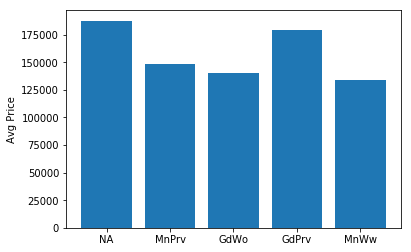

In [1479]:
value = []
feature = list(train_db['Fence'].unique())
for category in feature:
    value.append(train_db['SalePrice'][train_db['Fence'] == category].mean())
plt.bar(feature,value);
plt.ylabel('Avg Price');

From the average price we cant conclude which fence leads to increase in the price, hence we cant treat this variable as a ordinal and will convert it to a factor

In [1480]:
convert_factors.append('Fence')

#### Fireplace Variable


In [1481]:
# Read the description of FirePlace to figure out variable type
read_description('FireplaceQu')

FireplaceQu: Fireplace quality



       Ex	Excellent - Exceptional Masonry Fireplace

       Gd	Good - Masonry Fireplace in main level

       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement

       Fa	Fair - Prefabricated Fireplace in basement

       Po	Poor - Ben Franklin Stove

       NA	No Fireplace

		



In [1482]:
read_description('Fireplaces')

Fireplaces: Number of fireplaces





In [1483]:
# Distribution of fireplaces, all values are accounted for 
pd.value_counts(train_db['Fireplaces'])

0    690
1    649
2    115
3      4
Name: Fireplaces, dtype: int64

In [1484]:
# Distribution of fireplaces, all values are accounted for 
pd.value_counts(test_db['Fireplaces'])

0    730
1    618
2    104
3      6
4      1
Name: Fireplaces, dtype: int64

In [1485]:
# Number of nan values in fire place quality
len(train_db['FireplaceQu'][pd.isna(train_db['FireplaceQu'])])

690

In [1486]:
# Number of nan values in fire place quality
len(test_db['FireplaceQu'][pd.isna(test_db['FireplaceQu'])])

730

Number of entries with missing fireplace quality match the number of houses with 0 fireplace in train and test database, so we can safely replace the missing values with 'NA' for fireplace quality

In [1487]:
var_scan = 'FireplaceQu'
# Change all NaNs to NA, which is No Pool
train_db[var_scan][pd.isna(train_db[var_scan])] = 'NA'
test_db[var_scan][pd.isna(test_db[var_scan])] = 'NA'

In [1488]:
pd.value_counts(train_db['FireplaceQu'])

NA    690
Gd    378
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [1489]:
pd.value_counts(test_db['FireplaceQu'])

NA    730
Gd    364
TA    279
Fa     41
Po     26
Ex     19
Name: FireplaceQu, dtype: int64

Since the fireplace quality variable seems ordinal we will convert them to integer coding

In [1490]:
Qualities = {
    'NA':0,
    'Po':1,
    'Fa':2,
    'TA':3,
    'Gd':4,
    'Ex':5
}

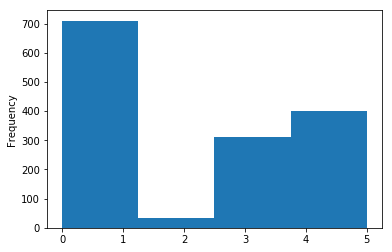

In [1491]:
var_scan = 'FireplaceQu'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)

train_db[var_scan].plot.hist(bins = 4);

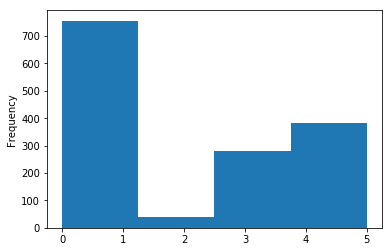

In [1492]:
var_scan = 'FireplaceQu'
# Encode levels as integers
encode_ordinal(var_scan, test_db, Qualities)

test_db[var_scan].plot.hist(bins = 4);

#### Lot variables
Lot variables include 'LotFrontage', 'LotArea','LotShape', LotConfig'

In [1493]:
read_description('LotFrontage')

LotFrontage: Linear feet of street connected to property





,LotArea,LotFrontage
LotArea,1.000000,0.483067
LotFrontage,0.483067,1.000000


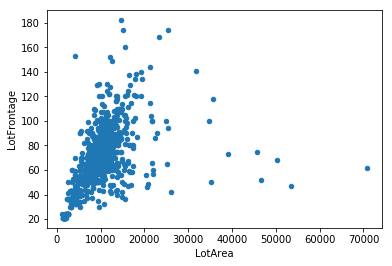

In [1494]:
# Test if lot area and lot frontage are correlated
subset = train_db[train_db['LotArea'] < 200000]
subset = subset[subset['LotFrontage'] < 250]
subset[['LotArea','LotFrontage']].plot.scatter(x=0,y=1)
subset[['LotArea','LotFrontage']].corr()

The correlation between lot frontage and lot area doesnt look strong

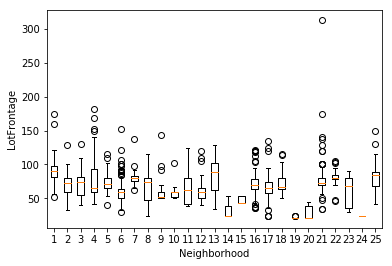

In [1495]:
train_db_LotFrontage_nonull = train_db[pd.isna(train_db['LotFrontage']) == False]
box_plot_data = [] 
for i in set(train_db_LotFrontage_nonull['Neighborhood']):
    subset = train_db_LotFrontage_nonull[train_db_LotFrontage_nonull ['Neighborhood'] == i]
    box_plot_data.append(subset['LotFrontage'].values)
plt.boxplot(box_plot_data);
plt.xlabel('Neighborhood');
plt.ylabel('LotFrontage');

In [1496]:
# We will imput the missing lotfrontage values as mean of the neighboorhood
for i in set(train_db_LotFrontage_nonull['Neighborhood']):
    subset = train_db_LotFrontage_nonull[train_db_LotFrontage_nonull ['Neighborhood'] == i]
    mean_lotfrontage = subset['LotFrontage'].mean()
    train_db['LotFrontage'][pd.isna(train_db['LotFrontage'])*(train_db['Neighborhood']==i)]=mean_lotfrontage
    test_db['LotFrontage'][pd.isna(test_db['LotFrontage'])*(test_db['Neighborhood']==i)]=mean_lotfrontage
  

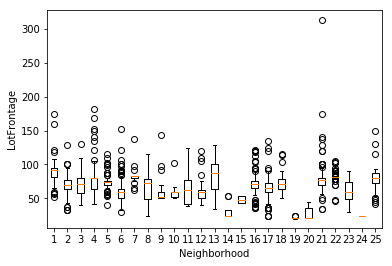

In [1497]:
# Check if we did not distort the original distribution
box_plot_data = [] 
for i in set(train_db['Neighborhood']):
    subset = train_db[train_db['Neighborhood'] == i]
    box_plot_data.append(subset['LotFrontage'].values)
plt.boxplot(box_plot_data);
plt.xlabel('Neighborhood');
plt.ylabel('LotFrontage');

In [1498]:
read_description('LotShape')

LotShape: General shape of property



       Reg	Regular	

       IR1	Slightly irregular

       IR2	Moderately Irregular

       IR3	Irregular

       



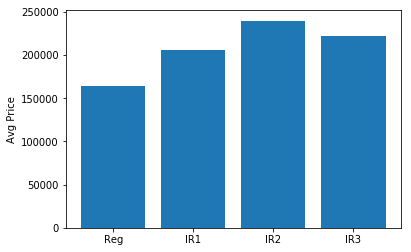

In [1499]:
value = []
feature = list(train_db['LotShape'].unique())
for category in feature:
    value.append(train_db['SalePrice'][train_db['LotShape'] == category].mean())
plt.bar(feature,value);
plt.ylabel('Avg Price');

From the average price we cant conclude any ordinality between various shape size of the lot

In [1500]:
# We will add LotShape variable for factor encoding
convert_factors.append('LotShape')

In [1501]:
read_description('LotConfig')

LotConfig: Lot configuration



       Inside	Inside lot

       Corner	Corner lot

       CulDSac	Cul-de-sac

       FR2	Frontage on 2 sides of property

       FR3	Frontage on 3 sides of property

	



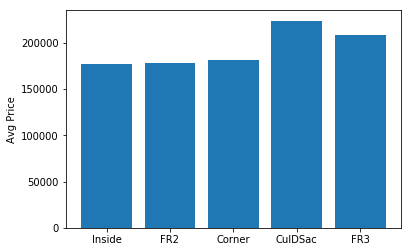

In [1502]:
value = []
feature = list(train_db['LotConfig'].unique())
for category in feature:
    value.append(train_db['SalePrice'][train_db['LotConfig'] == category].mean())
plt.bar(feature,value);
plt.ylabel('Avg Price');

From the average price we cant conclude any ordinality between various shape size of the lot

In [1503]:
# We will add LotShape variable for factor encoding
convert_factors.append('LotConfig')

#### Garage variables
'GarageType', 'GarageYrBlt','GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',

In [1504]:
# Read the description of the variable
read_description('GarageType')

GarageType: Garage location

		

       2Types	More than one type of garage

       Attchd	Attached to home

       Basment	Basement Garage

       BuiltIn	Built-In (Garage part of house - typically has room above garage)

       CarPort	Car Port

       Detchd	Detached from home

       NA	No Garage

		



We will replace the missing garage type by NA

In [1505]:
# Replace missing values, with no garages
var_scan = 'GarageType'
train_db[var_scan][pd.isna(train_db[var_scan])] = 'NA'
test_db[var_scan][pd.isna(test_db[var_scan])] = 'NA'

In [1506]:
pd.value_counts(train_db['GarageType'])

Attchd     869
Detchd     387
BuiltIn     87
NA          81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [1507]:
pd.value_counts(test_db['GarageType'])

Attchd     853
Detchd     392
BuiltIn     98
NA          76
2Types      17
Basment     17
CarPort      6
Name: GarageType, dtype: int64

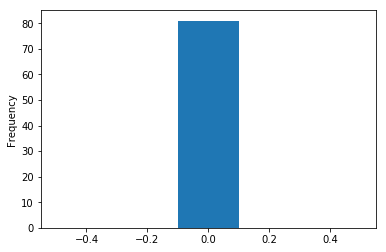

In [1508]:
# We also have information from other garage variables like GarageArea
train_db['GarageArea'][train_db['GarageType'] == 'NA'].plot.hist(bins=5);


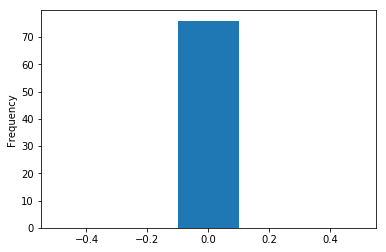

In [1509]:
test_db['GarageArea'][test_db['GarageType'] == 'NA'].plot.hist(bins=5);

All the houses with no garages line up with houses with 0 grage area, hence we were OK replacing the missing values with No Garages

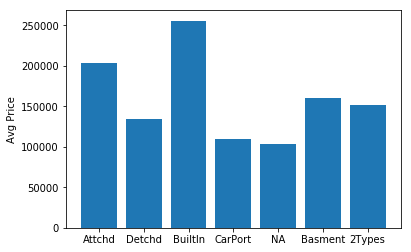

In [1510]:
value = []
feature = list(train_db['GarageType'].unique())
for category in feature:
    value.append(train_db['SalePrice'][train_db['GarageType'] == category].mean())
plt.bar(feature,value);
plt.ylabel('Avg Price');

From SalesPrice to GrageType plot we see there is some ordinality to the GarageType, houses with BuiltIn and Attached garages have higher prices then one which are detached or do not have garages, we will replace theis variable with integer values

In [1511]:
Qualities = {
    'NA':0,
    'CarPort':1,
    'Detchd':2,
    '2Types':3,
    'Basment':3,
    'Attchd':4,
    'BuiltIn':5
}

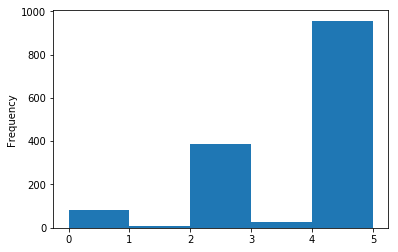

In [1512]:
var_scan = 'GarageType'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)

train_db[var_scan].plot.hist(bins = 5);

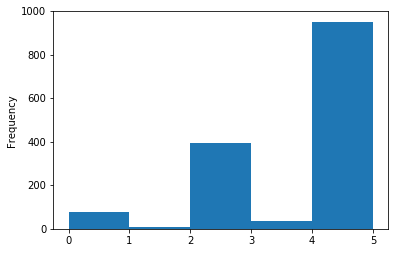

In [1513]:
var_scan = 'GarageType'
# Encode levels as integers
encode_ordinal(var_scan, test_db, Qualities)

test_db[var_scan].plot.hist(bins = 5);

In [1514]:
# Read the description of the variable
read_description('GarageYrBlt')


GarageYrBlt: Year garage was built

		



The missing GarageYrBlt can be either replaced by when the house was built or when it was remodeled, we will test which is abetter variable for imputing the missing values 

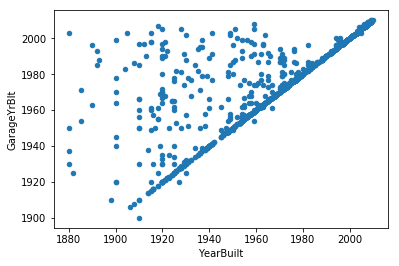

In [1515]:
train_db[['GarageYrBlt','YearBuilt','YearRemodAdd']].plot.scatter(x=1,y=0);

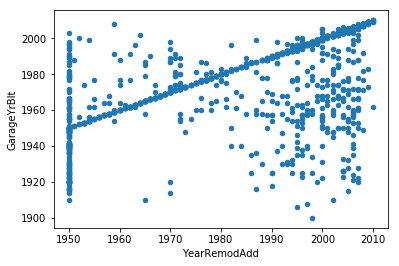

In [1516]:
train_db[['GarageYrBlt','YearBuilt','YearRemodAdd']].plot.scatter(x=2,y=0);

We will impute the missing values in the GarageYr with the year the house was built, since for most houses if there is a garage it would have been built along with main house construction

In [1517]:
train_db['GarageYrBlt'][pd.isna(train_db['GarageYrBlt'])] = train_db['YearBuilt'][pd.isna(train_db['GarageYrBlt'])]

In [1518]:
test_db['GarageYrBlt'][pd.isna(test_db['GarageYrBlt'])] = test_db['YearBuilt'][pd.isna(test_db['GarageYrBlt'])]

In [1519]:
read_description('GarageFinish')

GarageFinish: Interior finish of the garage



       Fin	Finished

       RFn	Rough Finished	

       Unf	Unfinished

       NA	No Garage

		



This category seems like an ordinal value (Finished > Rough > Unfinished > No Garage) and can be replaced with integer coding

We will replace the missing value with NA

In [1520]:
# Replace missing values, with no garages
var_scan = 'GarageFinish'
train_db[var_scan][pd.isna(train_db[var_scan])] = 'NA'
test_db[var_scan][pd.isna(test_db[var_scan])] = 'NA'

In [1521]:
pd.value_counts(train_db['GarageFinish'])

Unf    605
RFn    422
Fin    350
NA      81
Name: GarageFinish, dtype: int64

In [1522]:
pd.value_counts(test_db['GarageFinish'])

Unf    625
RFn    389
Fin    367
NA      78
Name: GarageFinish, dtype: int64

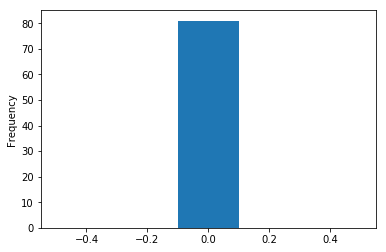

In [1523]:
# We also have information from other garage variables like GarageArea
train_db['GarageArea'][train_db['GarageFinish'] == 'NA'].plot.hist(bins=5);

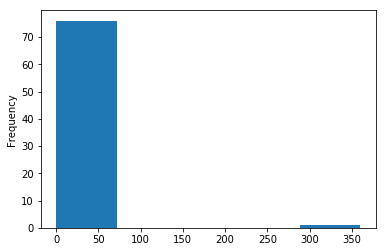

In [1524]:
# We also have information from other garage variables like GarageArea
test_db['GarageArea'][test_db['GarageFinish'] == 'NA'].plot.hist(bins=5);

Most garages with the garage finish as NA have 0 garage area which means we are correct in imputing the missing values as NA, however there is 1 exceptions in the test set, the other has nan value for garage area

In [1525]:
test_db[(test_db['GarageArea'] != 0) * (test_db['GarageFinish'] == 'NA')]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
666,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,0,0,MnPrv,Shed,1000,9,2008,WD,Normal
1116,70,RM,50.0,9060,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,MnPrv,NA,0,3,2007,WD,Alloca


In [1526]:
Qualities = {
    'NA':0,
    'Unf':1,
    'RFn':2,
    'Fin':3
}

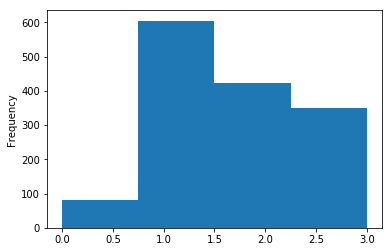

In [1527]:
var_scan = 'GarageFinish'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)

train_db[var_scan].plot.hist(bins = 4);

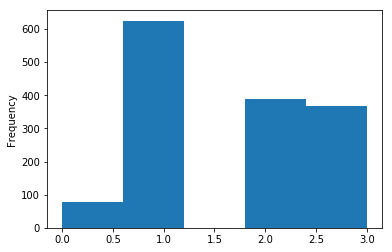

In [1528]:
var_scan = 'GarageFinish'
# Encode levels as integers
encode_ordinal(var_scan, test_db, Qualities)

test_db[var_scan].plot.hist(bins = 5);

In [1529]:
# Find the Overall Qualtiy which we will use for imputing the GarageFinish value
test_db.loc[[666]][['OverallQual','GarageArea','GarageFinish','GarageQual','GarageCond']]

,OverallQual,GarageArea,GarageFinish,GarageQual,GarageCond
666,6,360.0,0,NaN,NaN


In [1530]:
test_db['GarageFinish'].iloc[[666]] = [3]

In [1531]:
read_description('GarageQual')

GarageQual: Garage quality



       Ex	Excellent

       Gd	Good

       TA	Typical/Average

       Fa	Fair

       Po	Poor

       NA	No Garage

		



In [1532]:
read_description('GarageCond')

GarageCond: Garage condition



       Ex	Excellent

       Gd	Good

       TA	Typical/Average

       Fa	Fair

       Po	Poor

       NA	No Garage

		



The garage quality and garage condition seem to track the condition of the garage, the missing values are also identical. This variable can be encoded as an ordinal variable

In [1533]:
# Replace missing values, with no garages
var_scan = 'GarageQual'
train_db[var_scan][pd.isna(train_db[var_scan])] = 'NA'
test_db[var_scan][pd.isna(test_db[var_scan])] = 'NA'

In [1534]:
# Replace missing values, with no garages
var_scan = 'GarageCond'
train_db[var_scan][pd.isna(train_db[var_scan])] = 'NA'
test_db[var_scan][pd.isna(test_db[var_scan])] = 'NA'

In [1535]:
Qualities = {
    'NA':0,
    'Po':1,
    'Fa':2,
    'TA':3,
    'Gd':4,
    'Ex':5
}

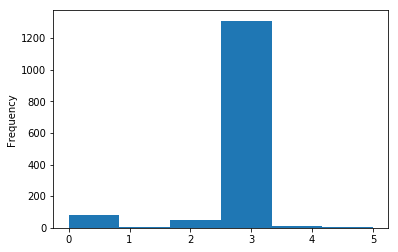

In [1536]:
var_scan = 'GarageQual'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)

train_db[var_scan].plot.hist(bins = 6);

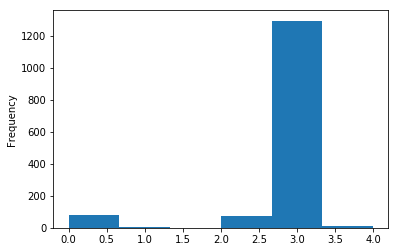

In [1537]:
var_scan = 'GarageQual'
# Encode levels as integers
encode_ordinal(var_scan, test_db, Qualities)

test_db[var_scan].plot.hist(bins = 6);

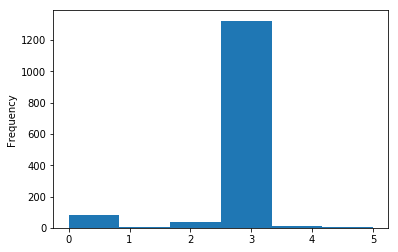

In [1538]:
var_scan = 'GarageCond'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)

train_db[var_scan].plot.hist(bins = 6);

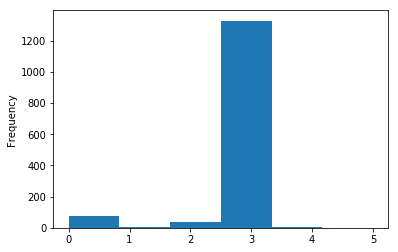

In [1539]:
var_scan = 'GarageCond'
# Encode levels as integers
encode_ordinal(var_scan, test_db, Qualities)

test_db[var_scan].plot.hist(bins = 6);

In [1540]:
# We have already seen that data[666] needs to be corrected for GarageQual and Condition which we will impute using Overall Quality
test_db.loc[[666]][['OverallQual','GarageArea','GarageFinish','GarageQual','GarageCond']]

,OverallQual,GarageArea,GarageFinish,GarageQual,GarageCond
666,6,360.0,3,0,0


In [1541]:
test_db['GarageQual'].iloc[[666]] = [6]
test_db['GarageCond'].iloc[[666]] = [6]

In [1542]:
read_description('GarageArea')

GarageArea: Size of garage in square feet





In [1543]:
read_description('GarageCars')

GarageCars: Size of garage in car capacity





The Garage Area and Car are highly correlated and have 1 NA

In [1544]:
test_db[pd.isna(test_db['GarageArea'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1116,70,RM,50.0,9060,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,MnPrv,NA,0,3,2007,WD,Alloca


In [1545]:
test_db[pd.isna(test_db['GarageCars'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1116,70,RM,50.0,9060,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,MnPrv,NA,0,3,2007,WD,Alloca


We will imput the GarageCars by the mode and Garage Area by the mean

In [1546]:
test_db['GarageCars'].loc[1116] = 2
test_db['GarageArea'].loc[1116] = 255
#train_db['GarageArea'][train_db['GarageYrBlt']==1923].mean()

#### Basement variables
'BsmtQual', 'BsmtCond','BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF'

In [1547]:
train_db[pd.isna(train_db['BsmtQual'])][['BsmtQual', 'BsmtCond','BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,NaN,NaN,0,NaN,0,0,0
39,NaN,NaN,NaN,NaN,0,NaN,0,0,0
90,NaN,NaN,NaN,NaN,0,NaN,0,0,0
102,NaN,NaN,NaN,NaN,0,NaN,0,0,0
156,NaN,NaN,NaN,NaN,0,NaN,0,0,0
182,NaN,NaN,NaN,NaN,0,NaN,0,0,0
259,NaN,NaN,NaN,NaN,0,NaN,0,0,0
342,NaN,NaN,NaN,NaN,0,NaN,0,0,0
362,NaN,NaN,NaN,NaN,0,NaN,0,0,0
371,NaN,NaN,NaN,NaN,0,NaN,0,0,0


Most missing values for basement corresponds to basement being not present seen from Total Basement Surface Area being 0, we will replace all categorical values with NA

In [1548]:
read_description('BsmtQual')

BsmtQual: Evaluates the height of the basement



       Ex	Excellent (100+ inches)	

       Gd	Good (90-99 inches)

       TA	Typical (80-89 inches)

       Fa	Fair (70-79 inches)

       Po	Poor (<70 inches

       NA	No Basement

		



In [1549]:
read_description('BsmtCond')

BsmtCond: Evaluates the general condition of the basement



       Ex	Excellent

       Gd	Good

       TA	Typical - slight dampness allowed

       Fa	Fair - dampness or some cracking or settling

       Po	Poor - Severe cracking, settling, or wetness

       NA	No Basement

	



In [1550]:
read_description('BsmtExposure')

BsmtExposure: Refers to walkout or garden level walls



       Gd	Good Exposure

       Av	Average Exposure (split levels or foyers typically score average or above)	

       Mn	Mimimum Exposure

       No	No Exposure

       NA	No Basement

	



In [1551]:
read_description('BsmtFinType1')

BsmtFinType1: Rating of basement finished area



       GLQ	Good Living Quarters

       ALQ	Average Living Quarters

       BLQ	Below Average Living Quarters	

       Rec	Average Rec Room

       LwQ	Low Quality

       Unf	Unfinshed

       NA	No Basement

		



In [1552]:
read_description('BsmtFinType2')

BsmtFinType2: Rating of basement finished area (if multiple types)



       GLQ	Good Living Quarters

       ALQ	Average Living Quarters

       BLQ	Below Average Living Quarters	

       Rec	Average Rec Room

       LwQ	Low Quality

       Unf	Unfinshed

       NA	No Basement





In [1553]:
# Replace missing values, with no basement
var_scan = 'BsmtQual'
train_db[var_scan][pd.isna(train_db[var_scan])] = 'NA'
test_db[var_scan][pd.isna(test_db[var_scan])] = 'NA'

In [1554]:
# Replace missing values, with no basement
var_scan = 'BsmtCond'
train_db[var_scan][pd.isna(train_db[var_scan])] = 'NA'
test_db[var_scan][pd.isna(test_db[var_scan])] = 'NA'

In [1555]:
# Replace missing values, with no basement
var_scan = 'BsmtExposure'
train_db[var_scan][pd.isna(train_db[var_scan])] = 'NA'
test_db[var_scan][pd.isna(test_db[var_scan])] = 'NA'

In [1556]:
# Replace missing values, with no basement
var_scan = 'BsmtFinType1'
train_db[var_scan][pd.isna(train_db[var_scan])] = 'NA'
test_db[var_scan][pd.isna(test_db[var_scan])] = 'NA'

In [1557]:
# Replace missing values, with no basement
var_scan = 'BsmtFinType2'
train_db[var_scan][pd.isna(train_db[var_scan])] = 'NA'
test_db[var_scan][pd.isna(test_db[var_scan])] = 'NA'

We will convert all these variables to ordinals by integer coding them

In [1558]:
Qualities = {
    'NA':0,
    'Po':1,
    'Fa':2,
    'TA':3,
    'Gd':4,
    'Ex':5
}


var_scan = 'BsmtQual'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

In [1559]:
Qualities = {
    'NA':0,
    'Po':1,
    'Fa':2,
    'TA':3,
    'Gd':4,
    'Ex':5
}


var_scan = 'BsmtCond'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

In [1560]:
Qualities = {
    'NA':0,
    'No':1,
    'Mn':2,
    'Av':3,
    'Gd':4,
}


var_scan = 'BsmtExposure'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

In [1561]:
Qualities = {
    'NA':0,
    'Unf':1,
    'LwQ':2,
    'Rec':3,
    'BLQ':4,
    'ALQ':5,
    'GLQ':6,
    
}


var_scan = 'BsmtFinType1'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

In [1562]:
Qualities = {
    'NA':0,
    'Unf':1,
    'LwQ':2,
    'Rec':3,
    'BLQ':4,
    'ALQ':5,
    'GLQ':6,
    
}


var_scan = 'BsmtFinType2'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

In [1563]:
count_null_ =dict()
# First cycle through training
for column in train_db.columns:
    num_null =len((train_db[column])[pd.isna(train_db[column])])
    count_null_[column] = num_null
# Then cycle through test data
for column in test_db.columns:
    num_null =len((test_db[column])[pd.isna(test_db[column])])
    count_null_[column]+=num_null
count_null_


{'MSSubClass': 0,
 'MSZoning': 4,
 'LotFrontage': 0,
 'LotArea': 0,
 'Street': 0,
 'Alley': 0,
 'LotShape': 0,
 'LandContour': 0,
 'Utilities': 2,
 'LotConfig': 0,
 'LandSlope': 0,
 'Neighborhood': 0,
 'Condition1': 0,
 'Condition2': 0,
 'BldgType': 0,
 'HouseStyle': 0,
 'OverallQual': 0,
 'OverallCond': 0,
 'YearBuilt': 0,
 'YearRemodAdd': 0,
 'RoofStyle': 0,
 'RoofMatl': 0,
 'Exterior1st': 1,
 'Exterior2nd': 1,
 'MasVnrType': 24,
 'MasVnrArea': 23,
 'ExterQual': 0,
 'ExterCond': 0,
 'Foundation': 0,
 'BsmtQual': 0,
 'BsmtCond': 0,
 'BsmtExposure': 0,
 'BsmtFinType1': 0,
 'BsmtFinSF1': 1,
 'BsmtFinType2': 0,
 'BsmtFinSF2': 1,
 'BsmtUnfSF': 1,
 'TotalBsmtSF': 1,
 'Heating': 0,
 'HeatingQC': 0,
 'CentralAir': 0,
 'Electrical': 1,
 '1stFlrSF': 0,
 '2ndFlrSF': 0,
 'LowQualFinSF': 0,
 'GrLivArea': 0,
 'BsmtFullBath': 2,
 'BsmtHalfBath': 2,
 'FullBath': 0,
 'HalfBath': 0,
 'BedroomAbvGr': 0,
 'KitchenAbvGr': 0,
 'KitchenQual': 1,
 'TotRmsAbvGrd': 0,
 'Functional': 2,
 'Fireplaces': 0,
 'Fir

In [1564]:
# Replace missing values, with no basement
var_scan = 'BsmtFinSF1'
train_db[var_scan][pd.isna(train_db[var_scan])] = 0
test_db[var_scan][pd.isna(test_db[var_scan])] = 0

In [1565]:
# Replace missing values, with no basement
var_scan = 'BsmtFinSF2'
train_db[var_scan][pd.isna(train_db[var_scan])] = 0
test_db[var_scan][pd.isna(test_db[var_scan])] = 0

In [1566]:
# Replace missing values, with no basement
var_scan = 'BsmtUnfSF'
train_db[var_scan][pd.isna(train_db[var_scan])] = 0
test_db[var_scan][pd.isna(test_db[var_scan])] = 0

In [1567]:
# Replace missing values, with no basement
var_scan = 'TotalBsmtSF'
train_db[var_scan][pd.isna(train_db[var_scan])] = 0
test_db[var_scan][pd.isna(test_db[var_scan])] = 0

#### Masanory Variables

In [1568]:
# Read the description of Masonary Type to figure out variable type
read_description('MasVnrType')

MasVnrType: Masonry veneer type



       BrkCmn	Brick Common

       BrkFace	Brick Face

       CBlock	Cinder Block

       None	None

       Stone	Stone

	



In [1569]:
# Find entries where both MasVnrType and Area are not known
train_db[pd.isna(train_db['MasVnrType'])&pd.isna(train_db['MasVnrArea'])][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [1570]:
test_db[(pd.isna(test_db['MasVnrType'])) & (pd.isna(test_db['MasVnrArea']))][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
231,NaN,NaN
246,NaN,NaN
422,NaN,NaN
532,NaN,NaN
544,NaN,NaN
581,NaN,NaN
851,NaN,NaN
865,NaN,NaN
880,NaN,NaN
889,NaN,NaN


For 23 of 24 entries both the MsnArea and MsnType are missing, which we will have to impute to None type for lack of more knowlege

In [1571]:
test_db[(pd.isna(test_db['MasVnrType'])) & (pd.isna(test_db['MasVnrArea'])==False)][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
1150,NaN,198.0


However in one entry we know the MsnVnrArea but dont know the type

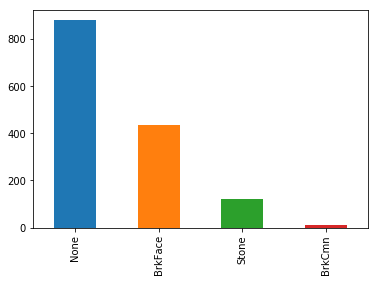

In [1572]:
pd.value_counts(test_db['MasVnrType']).plot.bar();

Most common masonary vener type is the Brick Face and we will impute the missing value with this type for lack of better information

In [1573]:
test_db['MasVnrType'].iloc[[1149]] = 'BrkFace'

In [1574]:
# For the remaining 23 values we will replace them with 'None'
# Replace missing values, with no basement
var_scan = 'MasVnrType'
train_db[var_scan][pd.isna(train_db[var_scan])] = 'None'
test_db[var_scan][pd.isna(test_db[var_scan])] = 'None'

In [1575]:
# Replace missing values, with no basement
var_scan = 'MasVnrArea'
train_db[var_scan][pd.isna(train_db[var_scan])] = 0
test_db[var_scan][pd.isna(test_db[var_scan])] = 0

There is some ordinality to Masonary Veneer Type given that cost of bricks, cinder and stone is different

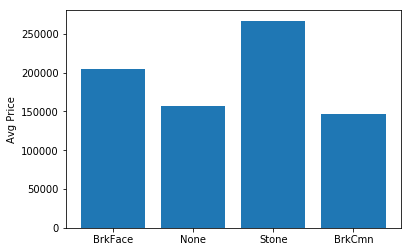

In [1576]:
value = []
feature = list(train_db['MasVnrType'].unique())
for category in feature:
    value.append(train_db['SalePrice'][train_db['MasVnrType'] == category].mean())
plt.bar(feature,value);
plt.ylabel('Avg Price');

Stone houses seem more expensive then brick which are inturn more expensive than Common Brick or Not having any veneer. There is not much difference between None and Common Brick

In [1577]:
Qualities = {
    'None':0,
    'BrkCmn':0,
    'CBlock':1,
    'BrkFace':2,
    'Stone':3,
}


var_scan = 'MasVnrType'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

#### MSZoning

In [1578]:
read_description('MSZoning')

MSZoning: Identifies the general zoning classification of the sale.

		

       A	Agriculture

       C	Commercial

       FV	Floating Village Residential

       I	Industrial

       RH	Residential High Density

       RL	Residential Low Density

       RP	Residential Low Density Park 

       RM	Residential Medium Density

	



The MS Zoning variable is a categorical variable

In [1579]:
# All 4 missing values are present in the test set
test_db[pd.isna(test_db['MSZoning'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,30,NaN,109.0,21780,Grvl,NA,Reg,Lvl,NaN,Inside,...,0,0,0,NA,NA,0,3,2009,ConLD,Normal
756,20,NaN,80.0,14584,Pave,NA,Reg,Low,AllPub,Inside,...,0,0,0,NA,NA,0,2,2008,WD,Abnorml
790,70,NaN,62.5,56600,Pave,NA,IR1,Low,AllPub,Inside,...,0,0,0,NA,NA,0,1,2008,WD,Normal
1444,20,NaN,125.0,31250,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,NA,NA,0,5,2006,WD,Normal


We will impute the missing values by most occuring zone in our data

In [1580]:
pd.value_counts(train_db['MSZoning'])

RL         1149
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [1581]:
# Replace missing values, with no basement
var_scan = 'MSZoning'
train_db[var_scan][pd.isna(train_db[var_scan])] = 'RL'
test_db[var_scan][pd.isna(test_db[var_scan])] = 'RL'

In [1582]:
# We will add LotShape variable for factor encoding
convert_factors.append('MSZoning')

#### Bathroom Variables
'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'

In [1583]:
test_db[pd.isna(test_db['BsmtFullBath'])][['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath']]

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath
660,NaN,NaN,1,0
728,NaN,NaN,3,1


In [1584]:
# Impute the missing values with 0
var_scan = 'BsmtFullBath'
train_db[var_scan][pd.isna(train_db[var_scan])] = 0
test_db[var_scan][pd.isna(test_db[var_scan])] = 0

In [1585]:
var_scan = 'BsmtHalfBath'
train_db[var_scan][pd.isna(train_db[var_scan])] = 0
test_db[var_scan][pd.isna(test_db[var_scan])] = 0

#### Kitchen Variables 
'KitchenQual'

In [1586]:
read_description('KitchenQual')

KitchenQual: Kitchen quality



       Ex	Excellent

       Gd	Good

       TA	Typical/Average

       Fa	Fair

       Po	Poor

       	



In [1587]:
# No missing data in training set
train_db[pd.isna(train_db['KitchenQual'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [1588]:
test_db[pd.isna(test_db['KitchenQual'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
95,50,RL,72.0,10632,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,0,NA,NA,0,1,2010,COD,Normal


In [1589]:
# Find the Overall Qualtiy which we will use for imputing the missing Kitchen Qual
test_db.loc[[95]][['OverallQual','KitchenQual']]

,OverallQual,KitchenQual
95,5,NaN


Since the house is of excellent quality we will impute the missing kitchen quality to be excellent also.

In [1590]:
test_db['KitchenQual'].loc[[95]] = 'Ex'

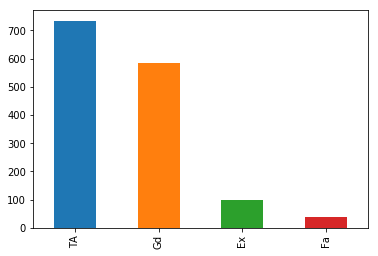

In [1591]:
pd.value_counts(train_db['KitchenQual']).plot.bar()

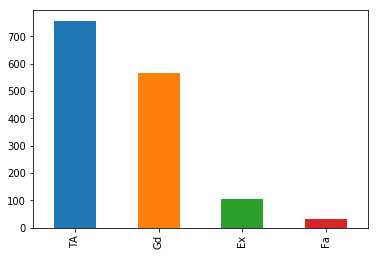

In [1592]:
pd.value_counts(test_db['KitchenQual']).plot.bar()

The Kitchen quality has some ordinality and we will integer code the variable

In [1593]:
Qualities = {
    'Po':0,
    'Fa':1,
    'TA':2,
    'Gd':3,
    'Ex':4,
}


var_scan = 'KitchenQual'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

In [1594]:
read_description('KitchenAbvGr')

#### Utilities: Type of utilities available

In [1595]:
read_description('Utilities')

Utilities: Type of utilities available

		

       AllPub	All public Utilities (E,G,W,& S)	

       NoSewr	Electricity, Gas, and Water (Septic Tank)

       NoSeWa	Electricity and Gas Only

       ELO	Electricity only	

	



In [1596]:
# No missing data
train_db[pd.isna(train_db['Utilities'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [1597]:
test_db[pd.isna(test_db['Utilities'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,30,RL,109.000000,21780,Grvl,NA,Reg,Lvl,NaN,Inside,...,0,0,0,NA,NA,0,3,2009,ConLD,Normal
485,20,RL,79.877551,31220,Pave,NA,IR1,Bnk,NaN,FR2,...,0,0,0,NA,Shed,750,5,2008,WD,Normal


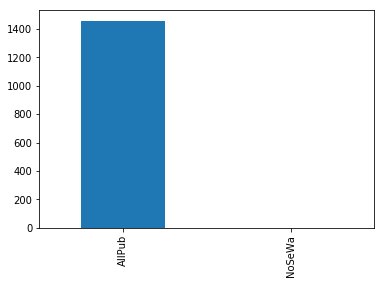

In [1598]:
pd.value_counts(train_db['Utilities']).plot.bar()

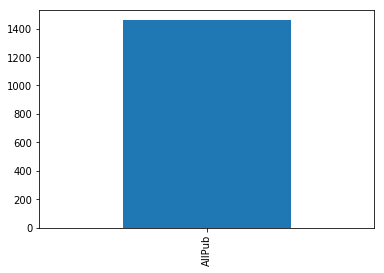

In [1599]:
pd.value_counts(test_db['Utilities']).plot.bar()

Imputing AllPub for NAs would mean that all houses in the test set will only have one value and this variable is not useful for prediction and we will get rid of it. 

In [1600]:
train_db = train_db.drop(['Utilities'], axis = 1);
test_db = test_db.drop(['Utilities'], axis = 1);

#### Functional: Home functionality

In [1601]:
read_description('Functional')

Functional: Home functionality (Assume typical unless deductions are warranted)



       Typ	Typical Functionality

       Min1	Minor Deductions 1

       Min2	Minor Deductions 2

       Mod	Moderate Deductions

       Maj1	Major Deductions 1

       Maj2	Major Deductions 2

       Sev	Severely Damaged

       Sal	Salvage only

		



We will imput the missing values as Typical, which is also the most occuring home type

In [1602]:
# No missing value in training set
train_db[pd.isna(train_db['Functional'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [1603]:
test_db[pd.isna(test_db['Functional'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
756,20,RL,80.0,14584,Pave,NA,Reg,Low,Inside,Mod,...,0,0,0,NA,NA,0,2,2008,WD,Abnorml
1013,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,Corner,Gtl,...,84,0,0,NA,NA,0,9,2007,COD,Abnorml


In [1604]:
test_db['Functional'].loc[[756,1013]] = 'Typ'

Since the home functinal variable type has some ordinality to it we can integer code it.

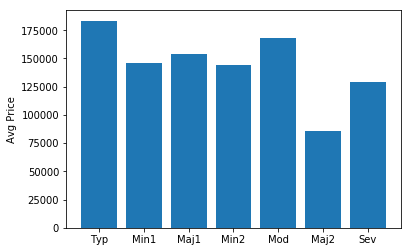

In [1605]:
value = []
feature = list(train_db['Functional'].unique())
for category in feature:
    value.append(train_db['SalePrice'][train_db['Functional'] == category].mean())
plt.bar(feature,value);
plt.ylabel('Avg Price');

In [1606]:
Qualities = {
    'Sal':0,
    'Sev':1,
    'Maj2':2,
    'Maj1':2,
    'Mod':3,
    'Min2':4,
    'Min1':4,
    'Typ':5
}


var_scan = 'Functional'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

#### Exterior Variables
 'Exterior1st', 'Exterior2nd','ExterQual','ExterCond'

In [1607]:
read_description('Exterior1st')

Exterior1st: Exterior covering on house



       AsbShng	Asbestos Shingles

       AsphShn	Asphalt Shingles

       BrkComm	Brick Common

       BrkFace	Brick Face

       CBlock	Cinder Block

       CemntBd	Cement Board

       HdBoard	Hard Board

       ImStucc	Imitation Stucco

       MetalSd	Metal Siding

       Other	Other

       Plywood	Plywood

       PreCast	PreCast	

       Stone	Stone

       Stucco	Stucco

       VinylSd	Vinyl Siding

       Wd Sdng	Wood Siding

       WdShing	Wood Shingles

	



In [1608]:
# No missing data in training set
train_db[pd.isna(train_db['Exterior1st'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [1609]:
# No missing data in training set
train_db[pd.isna(train_db['Exterior2nd'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [1610]:
test_db[pd.isna(test_db['Exterior1st'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
691,30,RL,85.0,19550,Pave,NA,Reg,Lvl,Inside,Gtl,...,0,0,0,NA,NA,0,1,2008,WD,Normal


In [1611]:
test_db[pd.isna(test_db['Exterior2nd'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
691,30,RL,85.0,19550,Pave,NA,Reg,Lvl,Inside,Gtl,...,0,0,0,NA,NA,0,1,2008,WD,Normal


In [1612]:
pd.value_counts(test_db['Exterior1st'])

VinylSd    510
MetalSd    230
HdBoard    220
Wd Sdng    205
Plywood    113
CemntBd     65
BrkFace     37
WdShing     30
AsbShng     24
Stucco      18
BrkComm      4
CBlock       1
AsphShn      1
Name: Exterior1st, dtype: int64

In [1613]:
# We will impute missing value by mode
test_db['Exterior1st'].loc[[691]] = 'VinylSd'
test_db['Exterior2nd'].loc[[691]] = 'VinylSd'

Since we dont have any ordinality we will encode this variable as one hot encoding

In [1614]:
# We will convert all features to factor encoding after we have analyzed all features
convert_factors.append('Exterior1st')
convert_factors.append('Exterior2nd')

We have two more variable ExterQual and ExterCond to deal with for this category

In [1615]:
read_description('ExterQual')

ExterQual: Evaluates the quality of the material on the exterior 

		

       Ex	Excellent

       Gd	Good

       TA	Average/Typical

       Fa	Fair

       Po	Poor

		



Since this variable has ordinality we will encode this variable with integer coding

In [1616]:
Qualities = {
    'Po':0,
    'Fa':1,
    'TA':2,
    'Gd':3,
    'Ex':4,
}


var_scan = 'ExterQual'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

In [1617]:
read_description('ExterCond')

ExterCond: Evaluates the present condition of the material on the exterior

		

       Ex	Excellent

       Gd	Good

       TA	Average/Typical

       Fa	Fair

       Po	Poor

		



In [1618]:
Qualities = {
    'Po':0,
    'Fa':1,
    'TA':2,
    'Gd':3,
    'Ex':4,
}


var_scan = 'ExterCond'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

#### Electrical: Electrical system

In [1619]:
read_description('Electrical')

Electrical: Electrical system



       SBrkr	Standard Circuit Breakers & Romex

       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	

       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)

       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)

       Mix	Mixed

		



In [1620]:
# Missing value in training set
train_db[pd.isna(train_db['Electrical'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,80,RL,73.0,9735,Pave,NA,Reg,Lvl,Inside,Gtl,...,0,0,NA,NA,0,5,2008,WD,Normal,167500


In [1621]:
train_db[pd.isna(train_db['Electrical'])][['OverallQual','Electrical']]

,OverallQual,Electrical
1379,5,NaN


Since the house with missing value has a high overall qual we will impute the missing value with SBrkr 

In [1622]:
train_db['Electrical'].loc[[1379]] = 'SBrkr'

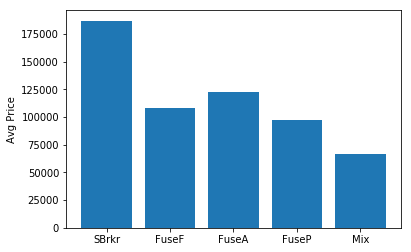

In [1623]:
value = []
feature = list(train_db['Electrical'].unique())
for category in feature:
    value.append(train_db['SalePrice'][train_db['Electrical'] == category].mean())
plt.bar(feature,value);
plt.ylabel('Avg Price');

There is an ordinality to the electrical system variable, houses with standard breaker are much higher priced then Fuse A, P and F, with Mixed systems with lowest price

In [1624]:
Qualities = {
    'Mix':0,
    'FuseP':1,
    'FuseF':2,
    'FuseA':3,
    'SBrkr':4,
}


var_scan = 'Electrical'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

#### Sales Type and Condition

In [1625]:
read_description('SaleType')

SaleType: Type of sale

		

       WD 	Warranty Deed - Conventional

       CWD	Warranty Deed - Cash

       VWD	Warranty Deed - VA Loan

       New	Home just constructed and sold

       COD	Court Officer Deed/Estate

       Con	Contract 15% Down payment regular terms

       ConLw	Contract Low Down payment and low interest

       ConLI	Contract Low Interest

       ConLD	Contract Low Down

       Oth	Other

		



The SaleType variable is Categorical and we will add it for one hot encoding

In [1626]:
train_db[pd.isna(train_db['SaleType'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [1627]:
test_db[pd.isna(test_db['SaleType'])]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1029,20,RL,85.0,13770,Pave,NA,Reg,Lvl,Corner,Gtl,...,0,0,0,NA,NA,0,10,2007,NaN,Normal


In [1628]:
# Imputing the missing value using the mode, Waranty Deed
test_db['SaleType'].loc[[1029]] = 'WD'

This value is categorical and we will encode it using factor  encoding

In [1629]:
convert_factors.append('SaleType')

In [1630]:
#read_description('SaleCondition')

There are no missing values, we will treat this variable as categorical

In [1631]:
convert_factors.append('SaleCondition')

At this point we should have taken care of all missing values, we still have to encode the remaining character variables before we procceed to building a model

In [1632]:
convert_factors.append('Foundation')
convert_factors.append('Heating')
convert_factors.append('RoofStyle')
convert_factors.append('RoofMatl')
convert_factors.append('LandContour')
convert_factors.append('LandSlope')
convert_factors.append('BldgType')
convert_factors.append('HouseStyle')
convert_factors.append('Neighborhood')
convert_factors.append('Condition1')
convert_factors.append('Condition2')
convert_factors.append('Street')

Convert following to integer coding HeatingQC, CentralAir, Street, PavedDrive

In [1633]:
Qualities = {
    'N':0,
    'P':1,
    'Y':2,
}


var_scan = 'PavedDrive'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

In [1634]:
Qualities = {
    'Grvl':0,
    'Pav':1,
}


var_scan = 'Street'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

In [1635]:
Qualities = {
    'Po':0,
    'Fa':1,
    'TA':2,
    'Gd':3,
    'Ex':4
}


var_scan = 'HeatingQC'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

In [1636]:
Qualities = {
    'N':0,
    'Y':1,
}


var_scan = 'CentralAir'
# Encode levels as integers
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

### Converting some numerical variable to factors

We will treat MSubClass also as a categorical variable and convert it into a factor

In [1637]:
convert_factors.append('MSSubClass')

### Visualization of important variables

In [1638]:
correlation = train_db.corr()
indx = list(correlation['SalePrice'].sort_values(ascending=False).index)[0:10]
corr_SalePrice = train_db[indx].corr()

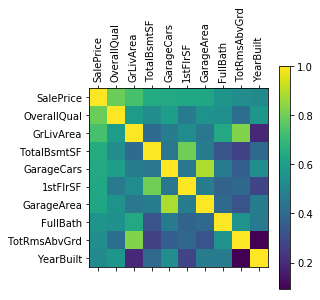

In [1639]:
plt.matshow(corr_SalePrice)
plt.colorbar()
plt.xticks(range(len(indx)),indx,rotation = 'vertical');
plt.yticks(range(len(indx)),indx,rotation = 'horizontal');

#### Above Ground Living Area, and other surface related variables (in square feet)

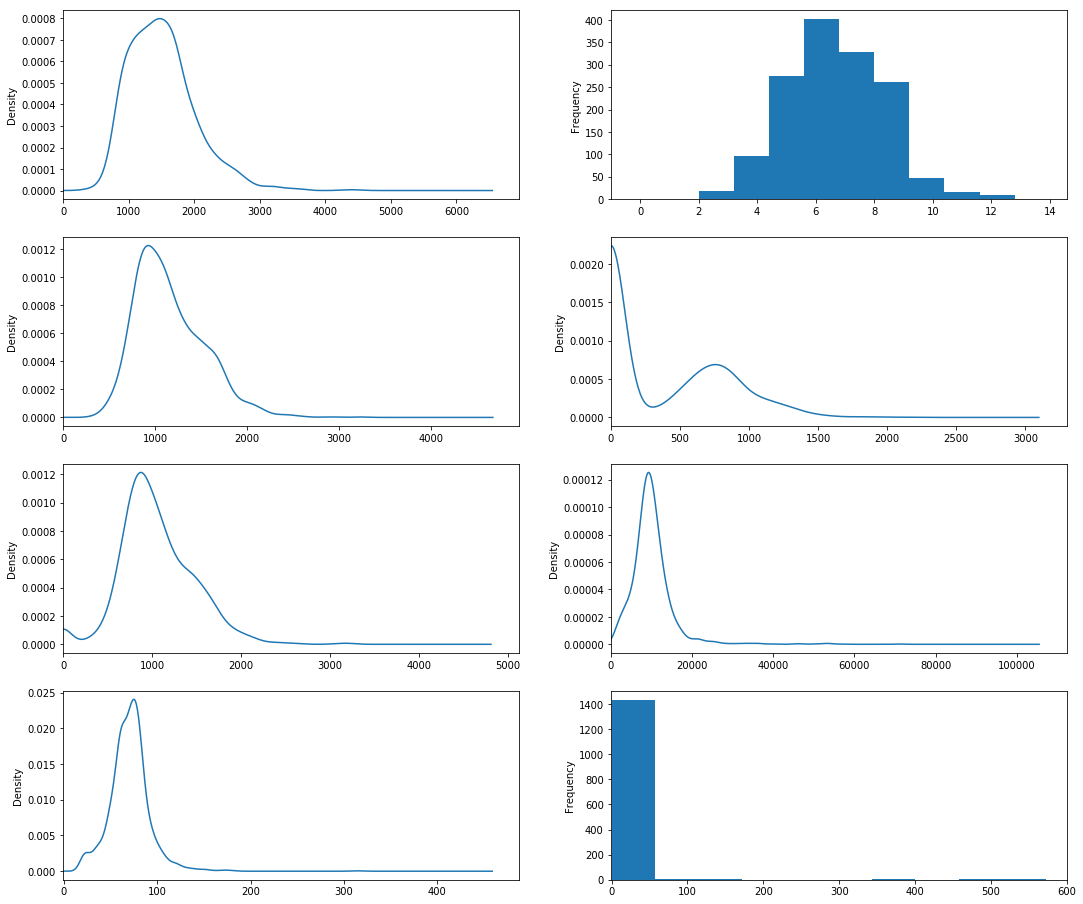

In [1640]:
fig, axs =plt.subplots(4,2, figsize=(18,16))
train_db['GrLivArea'].plot.density(ax=axs[0,0],xlim=-1)
train_db['TotRmsAbvGrd'].plot.hist(ax=axs[0,1],xlim=-1)
train_db['1stFlrSF'].plot.density(ax=axs[1,0],xlim=-1)
train_db['2ndFlrSF'].plot.density(ax=axs[1,1],xlim=-1)
train_db['TotalBsmtSF'].plot.density(ax=axs[2,0],xlim=-1)
train_db['LotArea'][(train_db['LotArea']<100000)].plot.density(ax=axs[2,1],xlim=-1)
train_db['LotFrontage'].plot.density(ax=axs[3,0],xlim=-1)
train_db['LowQualFinSF'].plot.hist(ax=axs[3,1],xlim=-1)

Correlation between Above Ground Living Area and 1st Floor Area + 2nd Floor + Low Quality Area is 1 indicating they are components making up Above Ground Living Area 

In [1641]:
train_db['GrLivArea'].corr(train_db['1stFlrSF']+train_db['2ndFlrSF']+train_db['LowQualFinSF'])

1.0

This can be confirmed by looking at the 3 areas for houses with LowQualFinSF  > 0 

In [1642]:
train_db[train_db['LowQualFinSF']>0][['GrLivArea','1stFlrSF','2ndFlrSF','LowQualFinSF']].head()

,GrLivArea,1stFlrSF,2ndFlrSF,LowQualFinSF
51,1176,816,0,360
88,1526,1013,0,513
125,754,520,0,234
170,1382,854,0,528
185,3608,1518,1518,572


#### Neighborhood

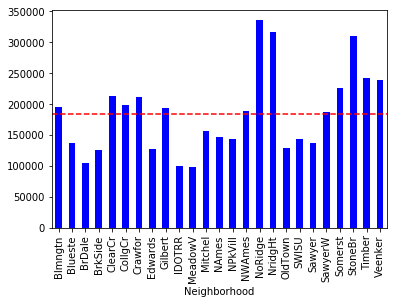

In [1643]:
df = train_db.groupby(['Neighborhood'])['SalePrice'].mean()
df.plot.bar(color='blue');
plt.axhline(df.mean(), color='r', linestyle='--');

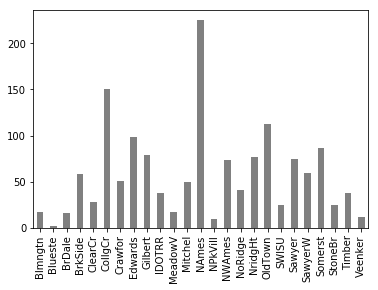

In [1644]:
train_db['Neighborhood'].value_counts().sort_index().plot.bar(color='grey');

## Feature Engineering

### Total Number of Bathrooms

In [1645]:
train_total_baths = train_db['FullBath'].values + train_db['HalfBath'].values + train_db['BsmtFullBath'].values + 0.5*train_db['BsmtHalfBath'].values

In [1646]:
df_train_total_baths = pd.DataFrame(train_total_baths,columns=['TotalBath'])

In [1647]:
# Reset index
train_db = train_db.reset_index(drop=True)
df_train_total_baths  = df_train_total_baths .reset_index(drop=True)

Correlation coefficient between TotalBathRooms and Sales Price 0.62


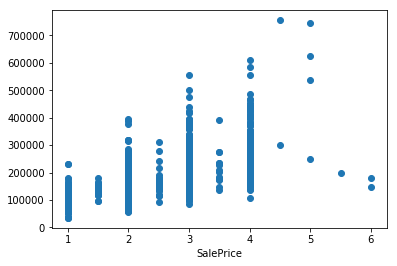

In [1648]:
plt.scatter(df_train_total_baths,train_db['SalePrice'])
plt.xlabel('TotalBathRooms');
plt.xlabel('SalePrice');
print('Correlation coefficient between TotalBathRooms and Sales Price {:.2f}'.format(np.corrcoef(np.squeeze(df_train_total_baths.values),train_db['SalePrice'].values)[0,1]))

In [1649]:
test_total_baths = test_db['FullBath'].values + test_db['HalfBath'].values + test_db['BsmtFullBath'].values + 0.5*test_db['BsmtHalfBath'].values
df_test_total_baths = pd.DataFrame(test_total_baths,columns=['TotalBath'])

In [1650]:
# Reset index
test_db = test_db.reset_index(drop=True)
df_test_total_baths  = df_test_total_baths .reset_index(drop=True)

### Adding house age, Remodeled and isNew variables

In [1651]:
train_remodeled = 1*(train_db['YearBuilt'] != train_db['YearRemodAdd']).values
df_train_remodeled  = pd.DataFrame(train_remodeled ,columns=['Remodeled'])

In [1652]:
test_remodeled = 1*(test_db['YearBuilt'] != test_db['YearRemodAdd']).values
df_test_remodeled  = pd.DataFrame(test_remodeled ,columns=['Remodeled'])

In [1653]:
train_age = (train_db['YrSold'] - train_db['YearRemodAdd']).values
df_train_age  = pd.DataFrame(train_age ,columns=['Age'])

In [1654]:
test_age = (test_db['YrSold'] - test_db['YearRemodAdd']).values
df_test_age  = pd.DataFrame(test_age ,columns=['Age'])

In [1655]:
train_new = 1*(train_db['YrSold'] == train_db['YearRemodAdd']).values
df_train_new  = pd.DataFrame(train_new ,columns=['isNew'])

In [1656]:
test_new = 1*(test_db['YrSold'] == test_db['YearRemodAdd']).values
df_test_new  = pd.DataFrame(test_new ,columns=['isNew'])

As expected the price of the house has a negative correlation with age of the house, i.e. older houses decrease have lower value

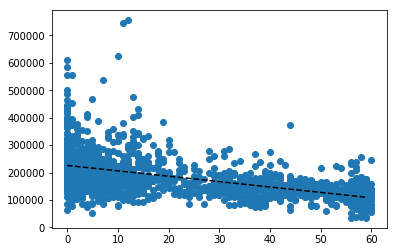

In [1657]:
plt.scatter(df_train_age,train_db['SalePrice']);
slope, intercept = np.polyfit(np.squeeze(df_train_age.values),train_db['SalePrice'].values,1)
plt.plot(np.arange(0,60),intercept + np.arange(0,60)*slope, 'k--');

Remodeled house on average sell at a slightly lower then houses which have not been remodeled, the dashed line is median of all houses in training set

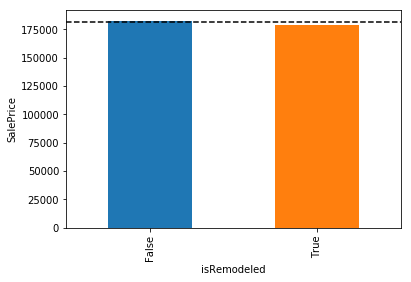

In [1658]:
train_db.groupby((train_db['YearBuilt'] != train_db['YearRemodAdd']))['SalePrice'].mean().plot.bar()
plt.axhline(train_db['SalePrice'].mean(),color='black',linestyle='--')
plt.xlabel('isRemodeled');
plt.ylabel('SalePrice');


New houses sell have been selling at premium to older houses 

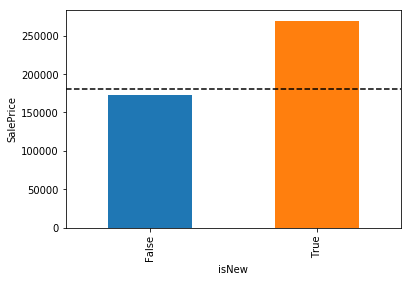

In [1659]:
train_db.groupby((train_db['YrSold'] == train_db['YearRemodAdd']))['SalePrice'].mean().plot.bar()
plt.axhline(train_db['SalePrice'].mean(),color='black',linestyle='--')
plt.xlabel('isNew');
plt.ylabel('SalePrice');

### Binning Neighboorhood

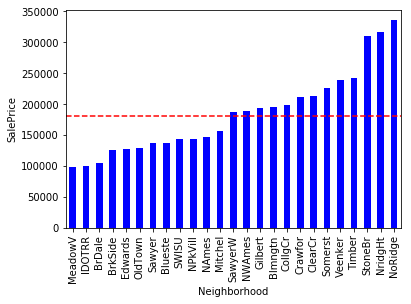

In [1660]:
train_db.groupby(['Neighborhood'])['SalePrice'].mean().sort_values().plot.bar(color='blue')
plt.axhline(train_db['SalePrice'].mean(),color='red',linestyle='--')
plt.ylabel('SalePrice');

In [1661]:
#train_db.groupby(['Neighborhood'])['SalePrice'].mean().sort_values().index

In [1662]:
Qualities = {
    'MeadowV':0, 
    'IDOTRR':0, 
    'BrDale':0, 
    'BrkSide':1, 
    'Edwards':1, 
    'OldTown':1,
    'Sawyer':2,
    'Blueste':2, 
    'SWISU':2, 
    'NPkVill':2, 
    'NAmes':2, 
    'Mitchel':2, 
    'SawyerW':3,
    'NWAmes':3, 
    'Gilbert':3, 
    'Blmngtn':3, 
    'CollgCr':3, 
    'Crawfor':4, 
    'ClearCr':4,
    'Somerst':5, 
    'Veenker':5, 
    'Timber':5, 
    'StoneBr':6, 
    'NridgHt':6, 
    'NoRidge':6
    
}


var_scan = 'Neighborhood'
# Bin Neighborhood
encode_ordinal(var_scan, train_db, Qualities)
encode_ordinal(var_scan, test_db, Qualities)

### Total Square Feet

In [1663]:
train_totalarea = train_db['GrLivArea'].values + train_db['TotalBsmtSF'].values 
df_train_totalarea = pd.DataFrame(train_totalarea,columns=['TotalAreaSF'])

In [1664]:
test_totalarea = test_db['GrLivArea'].values + test_db['TotalBsmtSF'].values 
df_test_totalarea = pd.DataFrame(test_totalarea,columns=['TotalAreaSF'])

Correlation coefficient between TotalBathRooms and Sales Price 0.83


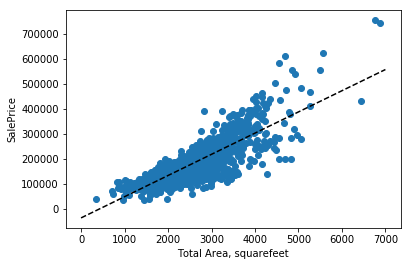

In [1665]:
plt.scatter(df_train_totalarea,train_db['SalePrice'])
slope, intercept = np.polyfit(np.squeeze(df_train_totalarea.values),train_db['SalePrice'].values,1)
plt.plot(np.arange(0,7000),intercept+slope*np.arange(0,7000),color='black',linestyle='--');
plt.xlabel('Total Area, squarefeet')
plt.ylabel('SalePrice')
print('Correlation coefficient between TotalBathRooms and Sales Price {:.2f}'.format(np.corrcoef(np.squeeze(df_train_totalarea.values),train_db['SalePrice'].values)[0,1]))

In [1666]:
train_db = train_db.join(df_train_total_baths) 
train_db = train_db.join(df_train_remodeled)
train_db = train_db.join(df_train_age)
train_db = train_db.join(df_train_new)
train_db = train_db.join(df_train_totalarea)

In [1667]:
test_db = test_db.join(df_test_total_baths) 
test_db = test_db.join(df_test_remodeled)
test_db = test_db.join(df_test_age)
test_db = test_db.join(df_test_new)
test_db = test_db.join(df_test_totalarea)

## Preparing Data for Modeling

## Remove outliers

We have already removed the two biggest outliers from training set, for now we will keep rest of the data

 ### Dropping highly correlated variables

In [1668]:
#train_db[list(train_db.corr()['SalePrice'].sort_values(ascending=False).index)].corr()

var_drop = set()
for var in list(train_db.corr()['SalePrice'].sort_values(ascending=False).index):
    if var not in var_drop:
        # Find strongly correlated variables 
        corr_df = train_db.corr()[var].sort_values(ascending=False)
        stongly_correlated_var = list(corr_df[abs(corr_df) > 0.80].index)
        stongly_correlated_var.remove(var)
        if len(stongly_correlated_var) !=0:
            for s in stongly_correlated_var:
                var_drop.add(s)

Highly correlated variable to drop from the dataset 

In [1669]:
var_drop.remove('Age') 
var_drop

{'1stFlrSF', 'GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd', 'TotalAreaSF'}

In [1670]:
train_db = train_db.drop(columns=list(var_drop))

In [1671]:
test_db = test_db.drop(columns=var_drop)

### PreProcessing predictor variables

In [1672]:
numeric_var = []
ordinal_var = []
for var in train_db.columns:
    if var not in convert_factors:
        if len(train_db[var].unique()) > 6:
            numeric_var.append(var)
        else:
            ordinal_var.append(var)

In [1673]:
convert_factors.append('Street')

In [1674]:
convert_factors

['MiscFeature',
 'Alley',
 'Fence',
 'LotShape',
 'LotConfig',
 'MSZoning',
 'Exterior1st',
 'Exterior2nd',
 'SaleType',
 'SaleCondition',
 'Foundation',
 'Heating',
 'RoofStyle',
 'RoofMatl',
 'LandContour',
 'LandSlope',
 'BldgType',
 'HouseStyle',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'Street',
 'MSSubClass',
 'Street']

In [1675]:
# Save backup of train and test
train_db_ = train_db
test_db_ = test_db

### Convert Factors to one hot encoding

In [1676]:
train_db = pd.get_dummies(train_db, columns = convert_factors)
test_db = pd.get_dummies(test_db, columns = convert_factors)

### Removing levels with few or no observations in train or test

Remove columns which appear in train but dont appear in test, or appear in test but dont appear in train

In [1677]:
col_not_test = set()
for col in train_db.columns:
    if (col not in test_db.columns) and (col != 'SalePrice'):
        col_not_test.add(col)

In [1678]:
train_db = train_db.drop(columns= list(col_not_test))

In [1679]:
col_not_train = set()
for col in test_db.columns:
    if (col not in train_db.columns) and (col != 'SalePrice'):
        col_not_train.add(col)

In [1680]:
test_db = test_db.drop(columns= list(col_not_train))

Also taking out variables with less than 10 ‘ones’ in the train set

In [1681]:
# Features with few occurances
col_few_ones = train_db.columns[train_db.sum()<10]

In [1682]:
train_db = train_db.drop(columns= list(col_few_ones))
test_db = test_db.drop(columns= list(col_few_ones))

In [1683]:
# If we removed Street_0 we should also remove Street_Pave (Something is wrong here, will need to go check)
train_db = train_db.drop(columns= ['Street_Pave'])
test_db = test_db.drop(columns= ['Street_Pave'])

In [1684]:
# Total number of variables and training data
train_db.shape

(1458, 166)

### Dealing with skewness of SalePrice

In [1685]:
# Skewness of sale price, we had note earlier there are few houses with very high value
train_db['SalePrice'].skew()

1.8812964895244009

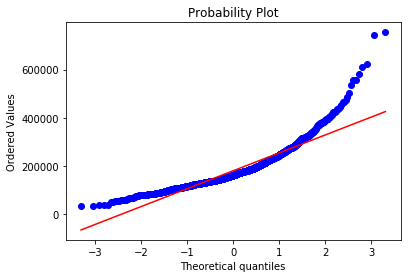

In [1686]:
import scipy.stats as stats
stats.probplot(train_db['SalePrice'], dist="norm",plot=plt)
plt.show()

The skew of 1.88 indicates a right skew that is too high, and the Q-Q plot shows that sale prices are also not normally distributed. We will take the log(SalePrice) to fix this issue

In [1687]:
train_db['SalePrice'].loc[:] = np.log(train_db['SalePrice'].values)

In [1688]:
# Adjusted Skewness
train_db['SalePrice'].skew()

0.12156821443518166

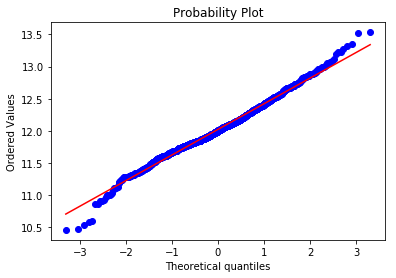

In [1689]:
import scipy.stats as stats
stats.probplot(train_db['SalePrice'], dist="norm",plot=plt)
plt.show()

In [1708]:
# Converting SalePrice back to raw values
train_db['SalePrice'].loc[:] = np.exp(train_db['SalePrice'].values)

In [1709]:
train_db = train_db.drop(columns= ['YearRemodAdd'])
test_db = test_db.drop(columns= ['YearRemodAdd'])

Save the data we will preprocess the data and use it for training a prediction algorithim

In [1424]:
train_db.to_csv('/data/train_cleaned.csv',index=False)

In [1425]:
test_db.to_csv('/data/test_cleaned.csv',index=False)